Trained Model Download

In [ ]:
!wget http://www.cs.toronto.edu/~rkiros/models/dictionary.txt
!wget http://www.cs.toronto.edu/~rkiros/models/utable.npy
!wget http://www.cs.toronto.edu/~rkiros/models/btable.npy
!wget http://www.cs.toronto.edu/~rkiros/models/uni_skip.npz
!wget http://www.cs.toronto.edu/~rkiros/models/uni_skip.npz.pkl
!wget http://www.cs.toronto.edu/~rkiros/models/bi_skip.npz
!wget http://www.cs.toronto.edu/~rkiros/models/bi_skip.npz.pkl

--2021-05-16 07:20:32--  http://www.cs.toronto.edu/~rkiros/models/dictionary.txt
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7996547 (7.6M) [text/plain]
Saving to: ‘dictionary.txt’

dictionary.txt      100%[===================>]   7.63M  13.3MB/s    in 0.6s    

2021-05-16 07:20:33 (13.3 MB/s) - ‘dictionary.txt’ saved [7996547/7996547]

--2021-05-16 07:20:33--  http://www.cs.toronto.edu/~rkiros/models/utable.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2342138474 (2.2G)
Saving to: ‘utable.npy’

utable.npy          100%[===================>]   2.18G  47.5MB/s    in 48s     

2021-05-16 07:21:20 (46.9 MB/s) - ‘utable.npy’ saved [2342138474/2342138474]

--2021-05-16 0

Data Loading

In [ ]:
from google.colab import drive

drive.mount('/content/data')

Mounted at /content/data


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Flatten, Embedding, Dropout, Reshape, Concatenate, Input, ReLU
import PIL
import os
import pickle

%matplotlib inline

In [ ]:
layers.

In [ ]:
#Paths

image_folder = 'data/MyDrive/flowers/jpg/'
caption_folder = 'data/MyDrive/flowers/text_c10/'
gen_path = 'data/MyDrive/flowers/T2I_gan/'
dic_path = 'daya/MyDrive/flowers/T2I_dic/'

In [ ]:
img1 = PIL.Image.open('data/MyDrive/flowers/jpg/image_08189.jpg')

In [ ]:
img1 = np.asarray(img1.resize((128, 128)))

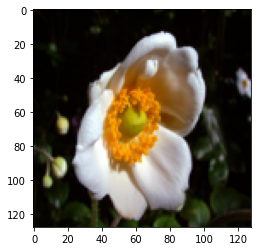

In [ ]:
plt.imshow(img1)

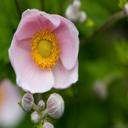

In [ ]:
PIL.Image.fromarray(img1)

In [ ]:
!ls

In [ ]:
#image_files = [f for f in os.listdir(image_folder) if 'jpg' in f]
image_files = np.load('data/MyDrive/flowers/img_files.npy')
#len(image_files)

In [ ]:
image_captions = { image_file : [] for image_file in image_files }

In [ ]:
class_dirs = []
for i in range(1, 103):
		class_dir_name = 'class_%.5d'%(i)
		class_dirs.append( os.path.join(caption_folder, class_dir_name))

for dir in class_dirs:
    caption_files = [f for f in os.listdir(dir) if 'txt' in f]
    for file in caption_files:
        with open(os.path.join(dir,file)) as f:
            captions = f.read().split('\n')
        img_file = file[0:11] + ".jpg"
        image_captions[img_file] += [cap for cap in captions if len(cap) > 0][0:5]

In [ ]:
len(image_captions)

8189

In [ ]:
with open('data/MyDrive/flowers/dict.pkl', 'wb') as f:
    pickle.dump(image_captions, f)

In [ ]:
with open('data/MyDrive/flowers/dict.pkl', 'rb') as f:
    image_captions = pickle.load(f)

In [ ]:
image_data = []

for image in image_files:
    image_data.append(np.asarray(PIL.Image.open(os.path.join(image_folder, image)).resize((128, 128))))

In [ ]:
image_data = np.array(image_data)

In [ ]:
#image_data.shape
image_data = (image_data - 127.5)/127.5

In [ ]:
image_data.shape

In [ ]:
np.save('data/MyDrive/flowers/imgs_256.npy', image_data)

In [ ]:
image_data = np.load('data/MyDrive/flowers/imgs.npy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


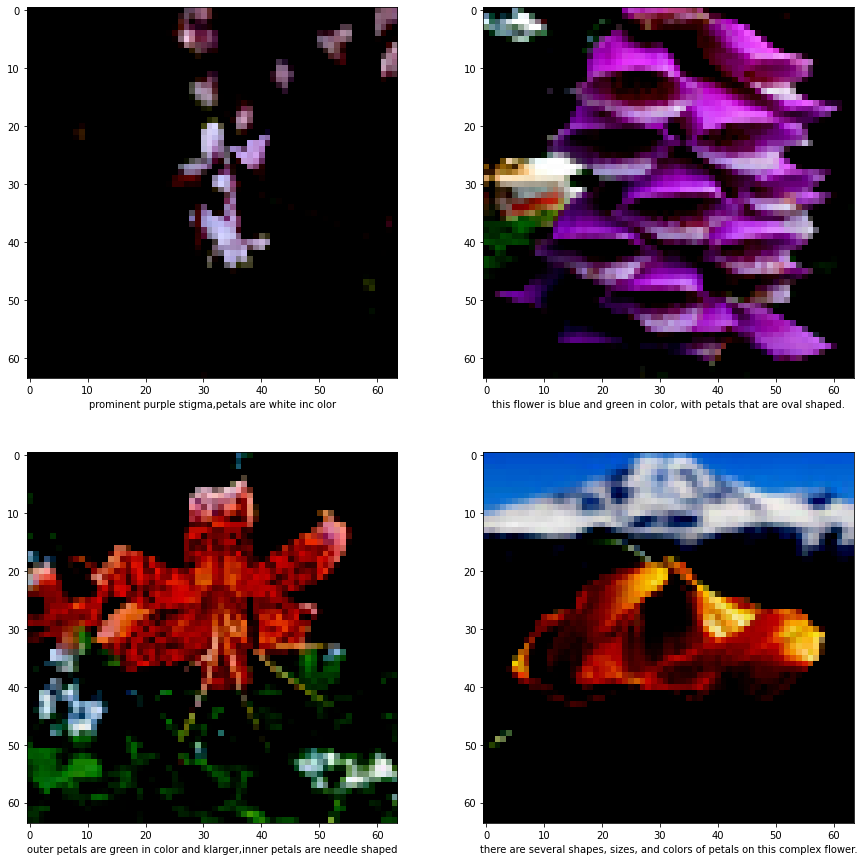

In [ ]:
plt.figure(figsize = (15, 15))
for i in range(4):
    plt.subplot(2, 2, i+1)
    #plt.axis('off')
    plt.imshow(image_data[i, :, :, :])
    plt.xlabel(image_captions[image_files[i]][0])

SkipThoughts

In [ ]:
'''
Skip-thought vectors
'''
import os

import theano
import theano.tensor as tensor

import _pickle as pkl
import numpy
import copy
import nltk

from collections import OrderedDict, defaultdict
from scipy.linalg import norm
from nltk.tokenize import word_tokenize

profile = False

#-----------------------------------------------------------------------------#
# Specify model and table locations here
#-----------------------------------------------------------------------------#
path_to_models = ''
path_to_tables = ''
#-----------------------------------------------------------------------------#

path_to_umodel = path_to_models + 'uni_skip.npz'
path_to_bmodel = path_to_models + 'bi_skip.npz'


def load_model():
    """
    Load the model with saved tables
    """
    # Load model options
    print('Loading model parameters...')
    with open('%s.pkl'%path_to_umodel, 'rb') as f:
        uoptions = pkl.load(f)
    with open('%s.pkl'%path_to_bmodel, 'rb') as f:
        boptions = pkl.load(f)

    # Load parameters
    uparams = init_params(uoptions)
    uparams = load_params(path_to_umodel, uparams)
    utparams = init_tparams(uparams)
    bparams = init_params_bi(boptions)
    bparams = load_params(path_to_bmodel, bparams)
    btparams = init_tparams(bparams)

    # Extractor functions
    print('Compiling encoders...')
    embedding, x_mask, ctxw2v = build_encoder(utparams, uoptions)
    f_w2v = theano.function([embedding, x_mask], ctxw2v, name='f_w2v')
    embedding, x_mask, ctxw2v = build_encoder_bi(btparams, boptions)
    f_w2v2 = theano.function([embedding, x_mask], ctxw2v, name='f_w2v2')

    # Tables
    print('Loading tables...')
    utable, btable = load_tables()

    # Store everything we need in a dictionary
    print('Packing up...')
    model = {}
    model['uoptions'] = uoptions
    model['boptions'] = boptions
    model['utable'] = utable
    model['btable'] = btable
    model['f_w2v'] = f_w2v
    model['f_w2v2'] = f_w2v2

    return model


def load_tables():
    """
    Load the tables
    """
    words = []
    utable = numpy.load(path_to_tables + 'utable.npy', allow_pickle=True, encoding='latin1')
    btable = numpy.load(path_to_tables + 'btable.npy', allow_pickle=True, encoding='latin1')
    f = open(path_to_tables + 'dictionary.txt', 'rb')
    for line in f:
        words.append(line.decode('utf-8').strip())
    f.close()
    utable = OrderedDict(zip(words, utable))
    btable = OrderedDict(zip(words, btable))
    return utable, btable


class Encoder(object):
    """
    Sentence encoder.
    """

    def __init__(self, model):
      self._model = model

    def encode(self, X, use_norm=True, verbose=True, batch_size=128, use_eos=False):
      """
      Encode sentences in the list X. Each entry will return a vector
      """
      return encode(self._model, X, use_norm, verbose, batch_size, use_eos)


def encode(model, X, use_norm=True, verbose=False, batch_size=128, use_eos=False):
    """
    Encode sentences in the list X. Each entry will return a vector
    """
    verbose = False
    # first, do preprocessing
    X = preprocess(X)

    # word dictionary and init
    d = defaultdict(lambda : 0)
    for w in model['utable'].keys():
        d[w] = 1
    ufeatures = numpy.zeros((len(X), model['uoptions']['dim']), dtype='float32')
    bfeatures = numpy.zeros((len(X), 2 * model['boptions']['dim']), dtype='float32')

    # length dictionary
    ds = defaultdict(list)
    captions = [s.split() for s in X]
    for i,s in enumerate(captions):
        ds[len(s)].append(i)

    # Get features. This encodes by length, in order to avoid wasting computation
    for k in ds.keys():
        if verbose:
            print(k)
        numbatches = (int)(len(ds[k]) / batch_size + 1)
        for minibatch in range(numbatches):
            caps = ds[k][minibatch::numbatches]

            if use_eos:
                uembedding = numpy.zeros((k+1, len(caps), model['uoptions']['dim_word']), dtype='float32')
                bembedding = numpy.zeros((k+1, len(caps), model['boptions']['dim_word']), dtype='float32')
            else:
                uembedding = numpy.zeros((k, len(caps), model['uoptions']['dim_word']), dtype='float32')
                bembedding = numpy.zeros((k, len(caps), model['boptions']['dim_word']), dtype='float32')
            for ind, c in enumerate(caps):
                caption = captions[c]
                for j in range(len(caption)):
                    if d[caption[j]] > 0:
                        uembedding[j,ind] = model['utable'][caption[j]]
                        bembedding[j,ind] = model['btable'][caption[j]]
                    else:
                        uembedding[j,ind] = model['utable']['UNK']
                        bembedding[j,ind] = model['btable']['UNK']
                if use_eos:
                    uembedding[-1,ind] = model['utable']['<eos>']
                    bembedding[-1,ind] = model['btable']['<eos>']
            if use_eos:
                uff = model['f_w2v'](uembedding, numpy.ones((len(caption)+1,len(caps)), dtype='float32'))
                bff = model['f_w2v2'](bembedding, numpy.ones((len(caption)+1,len(caps)), dtype='float32'))
            else:
                uff = model['f_w2v'](uembedding, numpy.ones((len(caption),len(caps)), dtype='float32'))
                bff = model['f_w2v2'](bembedding, numpy.ones((len(caption),len(caps)), dtype='float32'))
            if use_norm:
                for j in range(len(uff)):
                    uff[j] /= norm(uff[j])
                    bff[j] /= norm(bff[j])
            for ind, c in enumerate(caps):
                ufeatures[c] = uff[ind]
                bfeatures[c] = bff[ind]
    
    features = numpy.c_[ufeatures, bfeatures]
    return features


def preprocess(text):
    """
    Preprocess text for encoder
    """
    X = []
    sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
    for t in text:
        sents = sent_detector.tokenize(t)
        result = ''
        for s in sents:
            tokens = word_tokenize(s)
            result += ' ' + ' '.join(tokens)
        X.append(result)
    return X


def nn(model, text, vectors, query, k=5):
    """
    Return the nearest neighbour sentences to query
    text: list of sentences
    vectors: the corresponding representations for text
    query: a string to search
    """
    qf = encode(model, [query])
    qf /= norm(qf)
    scores = numpy.dot(qf, vectors.T).flatten()
    sorted_args = numpy.argsort(scores)[::-1]
    sentences = [text[a] for a in sorted_args[:k]]
    print('QUERY: ' + query)
    print('NEAREST: ')
    for i, s in enumerate(sentences):
        print(s, sorted_args[i])


def word_features(table):
    """
    Extract word features into a normalized matrix
    """
    features = numpy.zeros((len(table), 620), dtype='float32')
    keys = table.keys()
    for i in range(len(table)):
        f = table[keys[i]]
        features[i] = f / norm(f)
    return features


def nn_words(table, wordvecs, query, k=10):
    """
    Get the nearest neighbour words
    """
    keys = table.keys()
    qf = table[query]
    scores = numpy.dot(qf, wordvecs.T).flatten()
    sorted_args = numpy.argsort(scores)[::-1]
    words = [keys[a] for a in sorted_args[:k]]
    print('QUERY: ' + query)
    print('NEAREST: ')
    for i, w in enumerate(words):
        print(w)


def _p(pp, name):
    """
    make prefix-appended name
    """
    return '%s_%s'%(pp, name)


def init_tparams(params):
    """
    initialize Theano shared variables according to the initial parameters
    """
    tparams = OrderedDict()
    for kk, pp in params.items():
        tparams[kk] = theano.shared(params[kk], name=kk)
    return tparams


def load_params(path, params):
    """
    load parameters
    """
    pp = numpy.load(path)
    for kk, vv in params.items():
        if kk not in pp:
            print('%s is not in the archive'%kk)
            continue
        params[kk] = pp[kk]
    return params


# layers: 'name': ('parameter initializer', 'feedforward')
layers = {'gru': ('param_init_gru', 'gru_layer')}

def get_layer(name):
    fns = layers[name]
    return (eval(fns[0]), eval(fns[1]))


def init_params(options):
    """
    initialize all parameters needed for the encoder
    """
    params = OrderedDict()

    # embedding
    params['Wemb'] = norm_weight(options['n_words_src'], options['dim_word'])

    # encoder: GRU
    params = get_layer(options['encoder'])[0](options, params, prefix='encoder',
                                              nin=options['dim_word'], dim=options['dim'])
    return params


def init_params_bi(options):
    """
    initialize all paramters needed for bidirectional encoder
    """
    params = OrderedDict()

    # embedding
    params['Wemb'] = norm_weight(options['n_words_src'], options['dim_word'])

    # encoder: GRU
    params = get_layer(options['encoder'])[0](options, params, prefix='encoder',
                                              nin=options['dim_word'], dim=options['dim'])
    params = get_layer(options['encoder'])[0](options, params, prefix='encoder_r',
                                              nin=options['dim_word'], dim=options['dim'])
    return params


def build_encoder(tparams, options):
    """
    build an encoder, given pre-computed word embeddings
    """
    # word embedding (source)
    embedding = tensor.tensor3('embedding', dtype='float32')
    x_mask = tensor.matrix('x_mask', dtype='float32')

    # encoder
    proj = get_layer(options['encoder'])[1](tparams, embedding, options,
                                            prefix='encoder',
                                            mask=x_mask)
    ctx = proj[0][-1]

    return embedding, x_mask, ctx


def build_encoder_bi(tparams, options):
    """
    build bidirectional encoder, given pre-computed word embeddings
    """
    # word embedding (source)
    embedding = tensor.tensor3('embedding', dtype='float32')
    embeddingr = embedding[::-1]
    x_mask = tensor.matrix('x_mask', dtype='float32')
    xr_mask = x_mask[::-1]

    # encoder
    proj = get_layer(options['encoder'])[1](tparams, embedding, options,
                                            prefix='encoder',
                                            mask=x_mask)
    projr = get_layer(options['encoder'])[1](tparams, embeddingr, options,
                                             prefix='encoder_r',
                                             mask=xr_mask)

    ctx = tensor.concatenate([proj[0][-1], projr[0][-1]], axis=1)

    return embedding, x_mask, ctx


# some utilities
def ortho_weight(ndim):
    W = numpy.random.randn(ndim, ndim)
    u, s, v = numpy.linalg.svd(W)
    return u.astype('float32')


def norm_weight(nin,nout=None, scale=0.1, ortho=True):
    if nout == None:
        nout = nin
    if nout == nin and ortho:
        W = ortho_weight(nin)
    else:
        W = numpy.random.uniform(low=-scale, high=scale, size=(nin, nout))
    return W.astype('float32')


def param_init_gru(options, params, prefix='gru', nin=None, dim=None):
    """
    parameter init for GRU
    """
    if nin == None:
        nin = options['dim_proj']
    if dim == None:
        dim = options['dim_proj']
    W = numpy.concatenate([norm_weight(nin,dim),
                           norm_weight(nin,dim)], axis=1)
    params[_p(prefix,'W')] = W
    params[_p(prefix,'b')] = numpy.zeros((2 * dim,)).astype('float32')
    U = numpy.concatenate([ortho_weight(dim),
                           ortho_weight(dim)], axis=1)
    params[_p(prefix,'U')] = U

    Wx = norm_weight(nin, dim)
    params[_p(prefix,'Wx')] = Wx
    Ux = ortho_weight(dim)
    params[_p(prefix,'Ux')] = Ux
    params[_p(prefix,'bx')] = numpy.zeros((dim,)).astype('float32')

    return params


def gru_layer(tparams, state_below, options, prefix='gru', mask=None, **kwargs):
    """
    Forward pass through GRU layer
    """
    nsteps = state_below.shape[0]
    if state_below.ndim == 3:
        n_samples = state_below.shape[1]
    else:
        n_samples = 1

    dim = tparams[_p(prefix,'Ux')].shape[1]

    if mask == None:
        mask = tensor.alloc(1., state_below.shape[0], 1)

    def _slice(_x, n, dim):
        if _x.ndim == 3:
            return _x[:, :, n*dim:(n+1)*dim]
        return _x[:, n*dim:(n+1)*dim]

    state_below_ = tensor.dot(state_below, tparams[_p(prefix, 'W')]) + tparams[_p(prefix, 'b')]
    state_belowx = tensor.dot(state_below, tparams[_p(prefix, 'Wx')]) + tparams[_p(prefix, 'bx')]
    U = tparams[_p(prefix, 'U')]
    Ux = tparams[_p(prefix, 'Ux')]

    def _step_slice(m_, x_, xx_, h_, U, Ux):
        preact = tensor.dot(h_, U)
        preact += x_

        r = tensor.nnet.sigmoid(_slice(preact, 0, dim))
        u = tensor.nnet.sigmoid(_slice(preact, 1, dim))

        preactx = tensor.dot(h_, Ux)
        preactx = preactx * r
        preactx = preactx + xx_

        h = tensor.tanh(preactx)

        h = u * h_ + (1. - u) * h
        h = m_[:,None] * h + (1. - m_)[:,None] * h_

        return h

    seqs = [mask, state_below_, state_belowx]
    _step = _step_slice

    rval, updates = theano.scan(_step,
                                sequences=seqs,
                                outputs_info = [tensor.alloc(0., n_samples, dim)],
                                non_sequences = [tparams[_p(prefix, 'U')],
                                                 tparams[_p(prefix, 'Ux')]],
                                name=_p(prefix, '_layers'),
                                n_steps=nsteps,
                                profile=profile,
                                strict=True)
    rval = [rval]
    return rval

In [ ]:
skt_model = load_model()

Loading model parameters...
Compiling encoders...


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Loading tables...
Packing up...


In [ ]:
encoder = Encoder(skt_model)

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
vectors = encoder.encode(image_captions[image_files[0]])

In [ ]:
for i in range(len(vectors)):
    vectors[i] = process_vector(vectors[i])

Models

In [ ]:
def make_gen(latent_dim = 100, encoding_dim = 4800):
    input_latent = Input(shape = (latent_dim,))
    input_cap = Input(shape = (encoding_dim,))

    caption = Dense(16*16*1)(input_cap)
    caption = Reshape((16, 16, 1))(caption)

    image = Dense(16*16*128)(input_latent)
    image = LeakyReLU(alpha = 0.2)(image)
    image = Reshape((16, 16, 128))(image)

    merged = Concatenate()([image, caption])

    out = Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same')(merged)
    out = LeakyReLU(alpha = 0.2)(out)

    out = Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = 'same')(out)
    out = LeakyReLU(alpha = 0.2)(out)

    out = Conv2DTranspose(3, (3, 3), activation = 'tanh', padding = 'same')(out)

    model = Model([input_latent, input_cap], out)

    return model

In [ ]:
g_model = make_gen(encoding_dim = 200)
g_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32768)        3309568     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32768)        0           dense_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
def make_dic(input_shape = (64, 64, 3), encoding_dim = 4800):
    input_image = Input(shape = input_shape)
    input_cap = Input(shape = (encoding_dim,))

    caption = Dense(input_shape[0]*input_shape[1])(input_cap)
    caption = Reshape((input_shape[0], input_shape[1], 1))(caption)

    merged = Concatenate()([input_image, caption])

    out = Conv2D(64, (3, 3), strides = (2, 2), padding = 'same')(merged)
    out = LeakyReLU(alpha = 0.2)(out)

    out = Conv2D(64, (3, 3), strides = (2, 2), padding = 'same')(out)
    out = LeakyReLU(alpha = 0.2)(out)

    out = Flatten()(out)
    out = Dropout(0.4)(out)
    out = Dense(128, activation = 'relu')(out)
    out = Dropout(0.4)(out)
    out = Dense(1, activation = 'sigmoid')(out)

    model = Model([input_image, input_cap], out)

    opt = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [ ]:
d_model = make_dic(input_shape = (64, 64, 3), encoding_dim = 200)
d_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 4096)         823296      input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 64, 64, 1)    0           dense_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
def create_GAN(g_model, d_model):
    d_model.trainable = False

    gen_latent, gen_label = g_model.input
    gen_output = g_model.output

    dic_output = d_model([gen_output, gen_label])

    model = Model([gen_latent, gen_label], dic_output)

    opt = tf.keras.optimizers.Adam(learning_rate = 0.002, beta_1 = 0.5)

    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [ ]:
GAN = create_GAN(g_model, d_model)
GAN.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32768)        3309568     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32768)        0           dense_1[0][0]                    
____________________________________________________________________________________________

Training

In [ ]:
def process_vector(arr):
    avg_dim = 24
    processed_arr = []
    for i in range(int(len(arr)/avg_dim)):
        sum = 0
        for j in range(avg_dim*i, avg_dim*i + avg_dim):
            sum += arr[j]
        processed_arr.append(sum/avg_dim)
    return np.array(processed_arr)

In [ ]:
def generate_real_samples(image_captions, image_data, image_files, n_samples = 32):
    idx = np.random.randint(0, image_data.shape[0], n_samples)
    image_input = image_data[idx]
    
    caption_input = []
    for id in idx:
        num = np.random.randint(0, 5, 1)[0]
        caption_input.append(image_captions[image_files[id]][num])

    caption_input = encoder.encode(caption_input)

    caption_input1 = []
    for i in range(caption_input.shape[0]):
        caption_input1.append(process_vector(caption_input[i]))
    caption_input1 = np.array(caption_input1)
    
    out = np.ones((n_samples, 1))

    return [image_input, caption_input1], out

In [ ]:
def generate_wrong_samples(image_captions, image_data, image_files, n_samples = 32):
    [image_input, caption_input], _ = generate_real_samples(image_captions, image_data, image_files, n_samples)

    wrong_input = np.zeros((n_samples, 64, 64, 3))
    for i in range(0, n_samples):
        if i < n_samples - 1:
            wrong_input[i, :, :, :] = image_input[i+1, :, :, :]
        else:
            wrong_input[i, :, :, :] = image_input[0, :, :, :]

    out = np.zeros((n_samples, 1))

    return [wrong_input, caption_input], out

In [ ]:
def generate_latent_points(latent_dim = 100, n_samples = 96):
    (_, input_caption), _ = generate_real_samples(image_captions, image_data, image_files, n_samples)

    latent_input = np.random.randn(latent_dim*n_samples)
    latent_input = latent_input.reshape(n_samples, latent_dim)

    return [latent_input, input_caption]

In [ ]:
def generate_fake_samples(g_model, image_captions, image_data, image_files, n_samples = 32):
    [input_image, input_caption] = generate_latent_points(n_samples = n_samples)

    input_image = g_model.predict([input_image, input_caption])
    out = np.zeros((n_samples, 1))

    return [input_image, input_caption], out

In [ ]:
def save_fig(epoch, g_model, image_captions, image_files, latent_dim = 100):
    latent_input = np.random.randn(latent_dim*4)
    latent_input = latent_input.reshape(4, latent_dim)

    idx = np.random.randint(0, len(image_files), 4)
    input_caption1 = []
    
    for id in idx:
        num = np.random.randint(0, 5, 1)[0]
        input_caption1.append(image_captions[image_files[id]][num])
      
    input_caption1 = np.array(input_caption1)
    input_caption2 = encoder.encode(input_caption1)

    input_caption = []
    for i in range(4):
        input_caption.append(process_vector(input_caption2[i]))
    input_caption = np.array(input_caption)

    gen_img = g_model.predict([latent_input, input_caption])
    gen_img = (gen_img + 1) / 2.0

    #pillow_img = PIL.Image.fromarray(gen_img[0])
    #pillow_img.save('gen.jpg')

    plt.figure(figsize = (16, 12))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(gen_img[i, :, :, :])
        plt.xlabel(input_caption1[i])

    fname = 'T2I_GAN_epoch' + str(epoch) + '.jpg'
    plt.savefig(fname)

In [ ]:
def train_GAN(g_model, d_model, GAN, image_captions, image_data, image_files, latent_dim = 100, batch = 96, epochs = 5):
    batch_per_epoch = int(image_data.shape[0] / batch)
    temp_batch = int(batch / 3)

    real_loss = []
    wrong_loss = []
    fake_loss = []
    gan_loss = []

    for i in range(epochs):
        for j in range(batch_per_epoch):
            d_model.trainable = True
            [dic_real, dic_caption], dic_out = generate_real_samples(image_captions, image_data, image_files, n_samples = temp_batch)
            d_loss1, _ = d_model.train_on_batch([dic_real, dic_caption], dic_out)

            [dic_wrong, dic_caption], dic_out = generate_wrong_samples(image_captions, image_data, image_files, n_samples = temp_batch)
            d_loss2, _ = d_model.train_on_batch([dic_wrong, dic_caption], dic_out)

            [dic_fake, dic_caption], dic_out = generate_fake_samples(g_model, image_captions, image_data, image_files, n_samples = temp_batch)
            d_loss3, _ = d_model.train_on_batch([dic_fake, dic_caption], dic_out)

            d_model.trainable = False
            [gan_input, gan_caption] = generate_latent_points(n_samples = batch)
            gan_out = np.ones((batch, 1))
            g_loss1, _ = GAN.train_on_batch([gan_input, gan_caption], gan_out)

            [gan_input, gan_caption] = generate_latent_points(n_samples = batch)
            gan_out = np.ones((batch, 1))
            g_loss2, _ = GAN.train_on_batch([gan_input, gan_caption], gan_out)

            g_loss = (g_loss1 + g_loss2) / 2.0
            print("%d/%d - gan_loss: %.5f, d_loss1: %.5f, d_loss2: %.5f, d_loss3: %.5f" % (j + 1, batch_per_epoch, g_loss, d_loss1, d_loss2, d_loss3))

            real_loss.append(d_loss1)
            wrong_loss.append(d_loss2)
            fake_loss.append(d_loss3)

            #print("%d/%d - gan_loss: %.5f" % (j + 1, batch_per_epoch, g_loss))
            gan_loss.append(g_loss)

        g_avg_loss = np.mean(gan_loss)
        d_avg_loss1 = np.mean(real_loss)
        d_avg_loss2 = np.mean(wrong_loss)
        d_avg_loss3 = np.mean(fake_loss)

        real_loss = []
        wrong_loss = []
        fake_loss = []
        gan_loss = []

        print("------------------------------------------------------")
        print("Epoch %d - average_gan_loss: %.5f, average_d_loss1: %.5f, average_d_loss2: %.5f, average_d_loss3: %.5f" % (i + 1, g_avg_loss, d_avg_loss1, d_avg_loss2, d_avg_loss3))
        print("------------------------------------------------------")

        save_fig(i+1, g_model, image_captions, image_files)

    #g_model.save_weights('/data/MyDrive/flowers/generator')

1/85 - gan_loss: 0.94639, d_loss1: 0.97820, d_loss2: 0.47871, d_loss3: 0.51853
2/85 - gan_loss: 0.96405, d_loss1: 0.97970, d_loss2: 0.47349, d_loss3: 0.50930
3/85 - gan_loss: 0.99679, d_loss1: 1.01514, d_loss2: 0.48908, d_loss3: 0.49822
4/85 - gan_loss: 0.98456, d_loss1: 1.03933, d_loss2: 0.48076, d_loss3: 0.47405
5/85 - gan_loss: 0.96562, d_loss1: 1.01934, d_loss2: 0.47298, d_loss3: 0.50359
6/85 - gan_loss: 0.95913, d_loss1: 1.01802, d_loss2: 0.48592, d_loss3: 0.48146
7/85 - gan_loss: 0.94713, d_loss1: 0.97583, d_loss2: 0.47663, d_loss3: 0.50024
8/85 - gan_loss: 0.97033, d_loss1: 1.02394, d_loss2: 0.48293, d_loss3: 0.50514
9/85 - gan_loss: 0.98317, d_loss1: 1.01183, d_loss2: 0.48209, d_loss3: 0.49067
10/85 - gan_loss: 0.95351, d_loss1: 1.03798, d_loss2: 0.46996, d_loss3: 0.49603
11/85 - gan_loss: 0.97408, d_loss1: 1.00204, d_loss2: 0.45919, d_loss3: 0.49479
12/85 - gan_loss: 0.99001, d_loss1: 1.00956, d_loss2: 0.45891, d_loss3: 0.47913
13/85 - gan_loss: 1.00106, d_loss1: 1.03957, d_lo

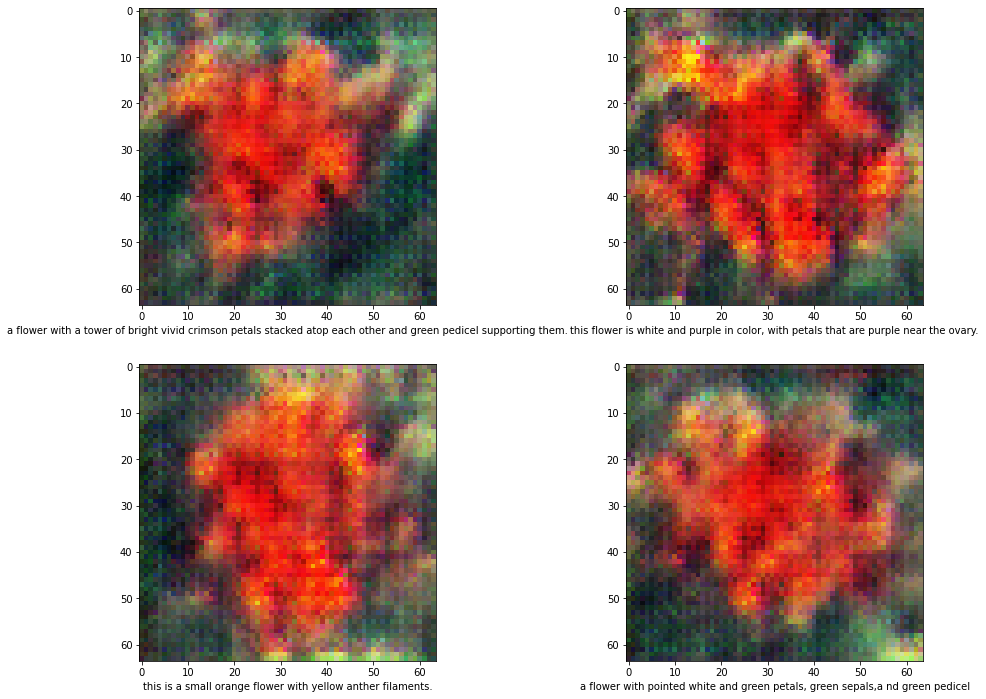

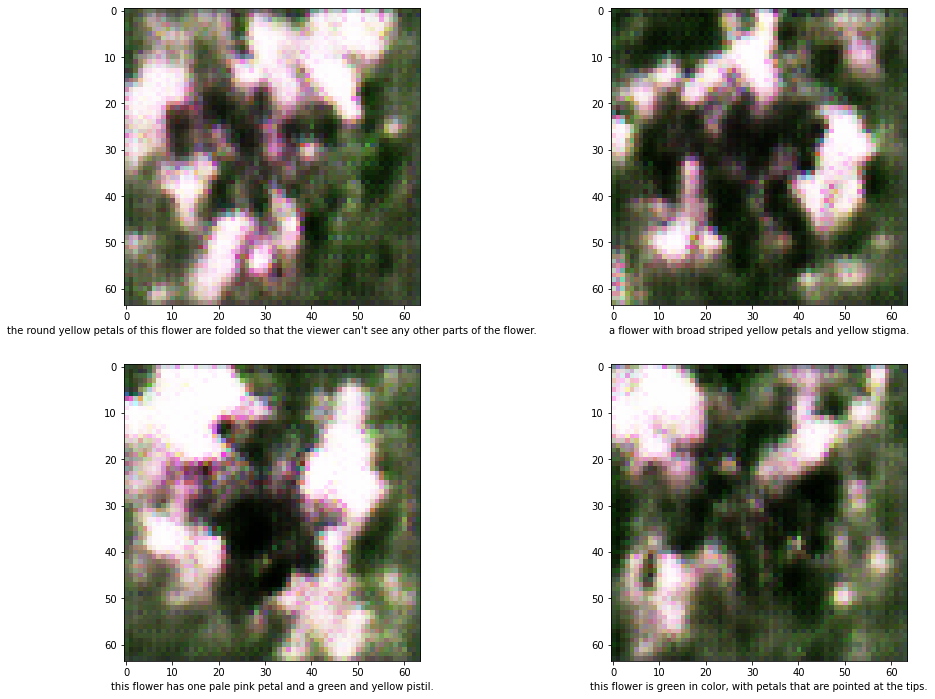

In [ ]:
train_GAN(g_model, d_model, GAN, image_captions, image_data, image_files, epochs = 2)

In [ ]:
g_model.save_weights('data/MyDrive/flowers/generaotor')
d_model.save_weights('data/MyDrive/flowers/discriminator')

In [ ]:
g_model.load_weights(os.path.join(gen_path, 'generaotor_5'))

In [ ]:
d_model.load_weights(os.path.join(dic_path, 'discriminator_5'))

In [ ]:
save_fig(1, g_model, image_captions, image_files)

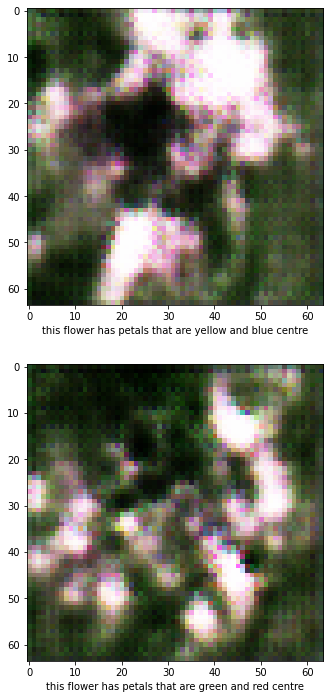

In [ ]:
latent_dim = 100
latent_input = np.random.randn(latent_dim*2)
latent_input = latent_input.reshape(2, latent_dim)

idx = np.random.randint(0, len(image_files), 4)
input_caption1 = ['this flower has petals that are yellow and blue centre', 'this flower has petals that are green and red centre']
"""
this blue flower has a beautiful orange center with many stamens
for id in idx:
    num = np.random.randint(0, 5, 1)[0]
    input_caption1.append(image_captions[image_files[id]][num])
"""
input_caption1 = np.array(input_caption1)
input_caption2 = encoder.encode(input_caption1)

input_caption = []
for i in range(2):
    input_caption.append(process_vector(input_caption2[i]))
input_caption = np.array(input_caption)

gen_img = g_model.predict([latent_input, input_caption])
gen_img = (gen_img + 1) / 2.0

plt.figure(figsize = (16, 12))
for i in range(2):
    plt.subplot(2,  1, i + 1)
    plt.imshow(gen_img[i, :, :, :], cmap = 'binary_r')
    plt.xlabel(input_caption1[i])

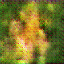

In [ ]:
img = gen_img[1]*255.0
img = img.astype(np.uint8)
PIL.Image.fromarray(img)